value means srcID, dstID

In [3]:
import dgl
import torch as th
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz as pgv
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Build the graph

In [4]:
# Load the graph nodes data file
f1 = h5py.File('./mesh_path.h5','r')
f2 = h5py.File('./path_reac.h5','r')
f3 = h5py.File('./reac_reac.h5','r')

In [5]:
# (src, dis) means 'src' has relationship with 'dis'
# Each variable is a tensor which contains the labels
src1 = f1['src']
src2 = f2['src']
src3 = f3['src']
dis1 = f1['dis']
dis2 = f2['dis']
dis3 = f3['dis']

In [6]:
# Build heterogeneous graph
# The term in the middle means the type of relationship
graph_data = {
    ('meshDescriptor', 'conclude', 'pathway'): (th.tensor(src1), th.tensor(dis1)),
    ('pathway', 'hasEvent', 'reaction'): (th.tensor(src2), th.tensor(dis2)),
    ('reaction', 'precedingEvent', 'reaction'): (th.tensor(src3), th.tensor(dis3)),
    ('pathway', 'belong', 'meshDescriptor'): (th.tensor(dis1), th.tensor(src1)),
    ('reaction', 'eventOf', 'pathway'): (th.tensor(dis2), th.tensor(src2)),
    ('reaction', 'laterEvent', 'reaction'): (th.tensor(dis3), th.tensor(src3))
}
G = dgl.heterograph(graph_data)
G

Graph(num_nodes={'meshDescriptor': 121, 'pathway': 209, 'reaction': 1277},
      num_edges={('meshDescriptor', 'conclude', 'pathway'): 345, ('pathway', 'hasEvent', 'reaction'): 1289, ('reaction', 'precedingEvent', 'reaction'): 955, ('pathway', 'belong', 'meshDescriptor'): 345, ('reaction', 'eventOf', 'pathway'): 1289, ('reaction', 'laterEvent', 'reaction'): 955},
      metagraph=[('meshDescriptor', 'pathway'), ('pathway', 'reaction'), ('pathway', 'meshDescriptor'), ('reaction', 'reaction'), ('reaction', 'reaction'), ('reaction', 'pathway')])

In [7]:
# Show the parameters of the graph
print('Node types:', G.ntypes)
print('Edge types:', G.etypes)
print('Canonical edge types:', G.canonical_etypes)

Node types: ['meshDescriptor', 'pathway', 'reaction']
Edge types: ['conclude', 'hasEvent', 'precedingEvent', 'belong', 'eventOf', 'laterEvent']
Canonical edge types: [('meshDescriptor', 'conclude', 'pathway'), ('pathway', 'hasEvent', 'reaction'), ('reaction', 'precedingEvent', 'reaction'), ('pathway', 'belong', 'meshDescriptor'), ('reaction', 'eventOf', 'pathway'), ('reaction', 'laterEvent', 'reaction')]


In [8]:
# Load the label data of pathway
# Label for each pathway is the ID of the mesh descriptors it belongs to
f4 = h5py.File('./label_path.h5','r')
label_pathway = f4['label_pathway']
label_pathway

<HDF5 dataset "label_pathway": shape (209,), type "<i8">

In [9]:
# transfer the label list into tensor format
label_pathway = torch.tensor(label_pathway).long()
len(label_pathway)
labels = label_pathway
labels

tensor([  0,   0, 117,   0, 117,  58,   0, 102,  14, 117, 117,   1,   2,  10,
          2,  39,  40,  14,  74, 110,  26, 107,  14,  75,  11,  19,  73,  59,
          8,  11,  62,   9,  62,  97,   9,   9,   9,   9,  12,  11,  28,  45,
         11,  26,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  45,  26,
         11,  11,  24,  11,  11,  45,  75,  11,  26,  86,  73,  11,  75,  11,
         86,  14, 109,  14,  39, 100,  14,  58,  14,  14, 104,  19,  19,  31,
        119,  21,  25,  25,  26,  26,  26,  26,  45,  28,  40,  28,  29,  33,
         33,  33,  33,  75,  38,  39,  40, 102,  40,  40,  40,  63,  95,  41,
         41,  43,  93,  97,  97,  49,  67,  53,  54,  89,  89,  57, 120,  58,
         67,  58,  58, 103,  58,  58, 102,  69,  58,  60,  60,  62,  62,  62,
         63,  65,  65,  65,  67,  67,  67,  67,  67,  67,  67,  67,  67,  67,
         67,  67,  67,  67,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
         75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  

In [10]:
# Cut the dataset into generate training set, validation set and test set
pid = list(range(209))
shuffle = np.random.permutation(pid)
train_idx = torch.tensor(shuffle[0:180]).long()
val_idx = torch.tensor(shuffle[160:200]).long()
test_idx = torch.tensor(shuffle[200:]).long()

#### Build the Relational-GCN based on heterograph

In [11]:
import dgl.function as fn

class HeteroRGCNLayer(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer, self).__init__()
        # W_r for each relation
        self.weight = nn.ModuleDict({
                name : nn.Linear(in_size, out_size) for name in etypes
            })
    def forward(self, G, feat_dict):
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # Calculate W_r * h
            Wh = self.weight[etype](feat_dict[srctype])
            # Store the result into the graph
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
        G.multi_update_all(funcs, 'sum')
        # Return the updated information for each node in dictionary format
        return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}

In [12]:
# Put two HeteroRGCNLayer together as a simple GNN

class HeteroRGCN(nn.Module):
    def __init__(self, G, in_size, hidden_size, out_size):
        super(HeteroRGCN, self).__init__()
        # Use trainable node embedding as featureless input.
        embed_dict = {ntype : nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), in_size))
                      for ntype in G.ntypes}
        for key, embed in embed_dict.items():
            nn.init.xavier_uniform_(embed)
        self.embed = nn.ParameterDict(embed_dict)
        # Build the layer
        self.layer1 = HeteroRGCNLayer(in_size, hidden_size, G.etypes)
        self.layer2 = HeteroRGCNLayer(hidden_size, out_size, G.etypes)
    def forward(self, G):
        h_dict = self.layer1(G, self.embed)
        h_dict = {k : F.leaky_relu(h) for k, h in h_dict.items()}
        h_dict = self.layer2(G, h_dict)
        # return the embedding feature of each pathway
        return h_dict['pathway']

In [16]:
# Create model. The model's output is 121 dimension, corresponding to the 121 MeSH Descriptors.
model = HeteroRGCN(G, 512, 1024, 121)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
best_val_acc = 0
best_test_acc = 0
lossFig = []
TraAcc = []
ValAcc = []
ValAcc = []
TesAcc = []
time = list(range(100))

for epoch in range(100):
    logits = model(G)
    # Calculate the loss only for marked nodes.
    loss = F.cross_entropy(logits[train_idx], labels[train_idx])
    pred = logits.argmax(1) 
    # Calculate the accuracy
    train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
    val_acc = (pred[val_idx] == labels[val_idx]).float().mean()
    test_acc = (pred[test_idx] == labels[test_idx]).float().mean()
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        print('Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
            loss.item(),
            train_acc.item(),
            val_acc.item(),
            #best_val_acc.item(),
            best_val_acc,
            test_acc.item(),
            #best_test_acc.item(),
            best_test_acc
        ))
    
    lossFig.append(loss.item())
    TraAcc.append(train_acc.item())
    ValAcc.append(val_acc.item())
    TesAcc.append(test_acc.item())

Loss 4.7965, Train Acc 0.0000, Val Acc 0.0000 (Best 0.0000), Test Acc 0.0000 (Best 0.0000)
Loss 0.5170, Train Acc 0.9000, Val Acc 0.7250 (Best 0.7250), Test Acc 0.6667 (Best 0.6667)
Loss 0.0563, Train Acc 0.9833, Val Acc 0.7500 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0256, Train Acc 0.9889, Val Acc 0.7250 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0187, Train Acc 1.0000, Val Acc 0.7750 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0547, Train Acc 1.0000, Val Acc 0.7250 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0407, Train Acc 1.0000, Val Acc 0.7250 (Best 0.8000), Test Acc 0.6667 (Best 0.7778)
Loss 0.0189, Train Acc 1.0000, Val Acc 0.7750 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0276, Train Acc 1.0000, Val Acc 0.7750 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0310, Train Acc 1.0000, Val Acc 0.7500 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)
Loss 0.0245, Train Acc 1.0000, Val Acc 0.7500 (Best 0.8000), Test Acc 0.7778 (Best 0.7778)

#### Save the model

In [17]:
torch.save(model.state_dict(),"./PathwayPredict.pth")

#### Visualize the result

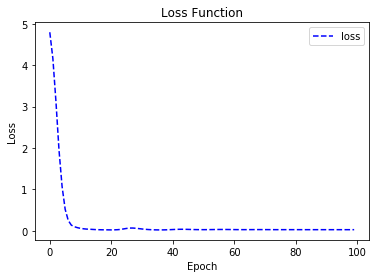

In [18]:
l = plt.plot(time, lossFig, 'b--', label = 'loss')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

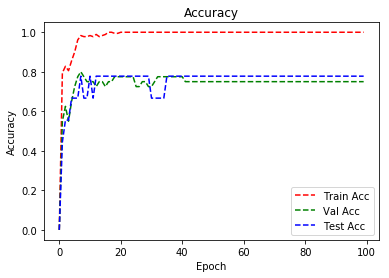

In [20]:
l1 = plt.plot(time, TraAcc, 'r--', label = 'Train Acc')
l2 = plt.plot(time, ValAcc, 'g--', label = 'Val Acc')
l3 = plt.plot(time, TesAcc, 'b--', label = 'Test Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Draw the meta graph

In [6]:
# use graphviz to build the meta graph.
def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')
plot_graph(G.metagraph)